In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import copy

from cv2 import imread
from cv2 import imshow
from cv2 import waitKey
from cv2 import destroyAllWindows
from cv2 import CascadeClassifier
from cv2 import rectangle
import cv2

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

from sklearn.metrics import f1_score

from termcolor import colored

import tqdm
from pathlib import Path
import PIL
import math
import random

%matplotlib inline

In [149]:
class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        def conv_block(in_channels, out_channels, pool=False):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                      nn.BatchNorm2d(out_channels), 
                      nn.ELU(inplace=True)]
            if pool:
                layers.append(nn.MaxPool2d(2))
            return nn.Sequential(*layers)
        
        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(64, num_classes))
        
    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        return self.classifier(out)

In [150]:
def readImg(path, show=False):
    pixels = imread(path)
    if show:
        plt.figure()
        plt.imshow(cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)) 
        plt.show()  # display it
        print(pixels.shape)
    return pixels


def showImg(img):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    plt.show()  # display it

In [151]:
def getFace(img, count=1):
    #print(2)
    classifier = CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
    bboxes = classifier.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)
    i = 1
    #print(1)
    for box in bboxes:
        x, y, width, height = box
        x2, y2 = x + width, y + height
        crop_img = img[y:y2, x:x2]
        #print(crop_img)
        
        yield crop_img
        
        if count is not None and count <= i:
            break
        i += 1
        
        
def getDataLoader(ds_dir, batch_size, train=True, cut=False, shuffle=False, num_workers=0):
    
    def getOneFace(img):
        for face in getFace(img, count=1):
            return face
        return np.zeros(img.shape).astype(np.uint8)

    if train:
        if cut:
            tfms = tt.Compose([tt.Lambda(lambda x: getOneFace(np.array(x))), 
                               tt.ToPILImage(),
                               tt.Grayscale(num_output_channels=1),
                               tt.Resize([int(50), int(50)]),
                               tt.RandomHorizontalFlip(),
                               tt.RandomRotation(15),
                               tt.ToTensor()])
        else:
            tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                               tt.Resize([int(50), int(50)]),
                               tt.RandomHorizontalFlip(),
                               tt.ToTensor()])
    else:
        if cut:
            tfms = tt.Compose([tt.Lambda(lambda x: getOneFace(np.array(x))),
                               tt.ToPILImage(),
                               tt.Grayscale(num_output_channels=1),
                               tt.Resize([int(50), int(50)]),
                               tt.ToTensor()])
        else:
            tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                               tt.Resize([int(50), int(50)]),
                               tt.ToTensor()])
    
    data_classes = os.listdir(ds_dir)
    ds = ImageFolder(ds_dir, tfms)
    dl = DataLoader(ds, (batch_size if train else batch_size*2),
                    num_workers=num_workers, pin_memory=True, shuffle=shuffle)
    
    return dl


def hightlineFaces(img, count=1):
    pixels = img.copy()
    classifier = CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
    bboxes = classifier.detectMultiScale(pixels, scaleFactor=1.1, minNeighbors=6) # посмотреть
    i = 1
    for box in bboxes:
        x, y, width, height = box
        x2, y2 = x + width, y + height
        crop_img = pixels[y:y2, x:x2]
        
        rectangle(pixels, (x, y), (x2, y2), (0,0,255), 1)
        
        if count is not None and count <= i:
            break
        i += 1
    plt.figure()
    plt.imshow(cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)) 
    plt.show()  # display it
        
        
def predictOne(model, img, classes, device, mode='emotion', masks=None, show=False, probs=True):
    '''
    mode = [emotion, mask]
    '''
    #plt.figure()
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    #plt.show()  # display it
    
    ray_image = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (50, 50))
    
    if show:
        showImg(ray_image)
    
    tfms = tt.Compose([tt.ToPILImage(),
                       tt.Grayscale(num_output_channels=1),
                       tt.Resize([int(50), int(50)]),
                       tt.ToTensor()])
    
    ray_image = tfms(ray_image).unsqueeze(0)
    model.eval()
    img = to_device(ray_image, device) # to GPU !!! не забыть что модель хз где лежит
    output = model(img)
    pred = torch.max(output, dim=1)[1].tolist()
    label = classes[pred[0]]
    classes_per = sorted(zip(torch.nn.Softmax(dim=1)(output)[0].tolist(), classes), key=lambda x: x[0], reverse=True)

    if mode == 'emotion':
        print(colored(label, attrs=['bold']))
        if probs==True:
            for pr, lb in classes_per:
                print(lb, "{:.1%}".format(pr))
    elif mode == 'mask':
        if(masks is None):
            print("No mask")
            return
        print(colored(masks[label], attrs=['bold']))
        if probs==True:
            masks_probs = dict.fromkeys(set(masks.values()), 0.0)
            for pr, lb in classes_per:
                masks_probs[masks[lb]] += pr
            for m in dict(sorted(masks_probs.items(), key=lambda item: item[1], reverse=True)):
                print(m, "{:.1%}".format(masks_probs[m]))

        
def predictForImg(model, img_path, count=None, device='cuda'):
    for img in getFace(imread(img_path), count=count):
        predictOne(model, img, device)

In [152]:
v = dict.fromkeys(set(masks.values()), 0.0)
for i in v:
    print(i)

Happy
Neutral
Bad


In [153]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [154]:
def accuracy(outputs, labels, mask=False, mask_labels=None):
    # labels must be dict if mask==True
    _, preds = torch.max(outputs, dim=1)
    if mask==True:
        for i in range(preds.shape[0]):
            preds[i] = mask_labels[preds[i].item()]
            labels[i] = mask_labels[labels[i].item()]
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    else:
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch, mask=False, mask_labels=None, multi_accuracy=False):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        if multi_accuracy:
            acc = accuracy_multi(out, labels, mask=mask, mask_labels=mask_labels)
        else:
            acc = accuracy(out, labels, mask=mask, mask_labels=mask_labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs, multi_accuracy=False):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        #print(batch_accs)
        if multi_accuracy:
            labels = []
            for i in batch_accs:
                labels = labels + list(i.keys())
            labels = {i: [0,0] for i in set(labels)}
            for i in batch_accs:
                for j in i.keys():
                    labels[j][0] += i[j][0]
                    labels[j][1] += i[j][1]
            epoch_acc = {i: ( 0 if labels[i][1] == 0 else labels[i][1] / labels[i][0]) for i in labels.keys()}
            return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc}
        else:
            epoch_acc = torch.stack(batch_accs).mean()
            return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [155]:
def calcAccuracy(model, dl, mask=False, mask_labels=None, multi_accuracy=False, labels=None, str_format=True):
    result = []
    if multi_accuracy:
        acs = evaluate(model, dl, mask=mask, mask_labels=mask_labels, multi_accuracy=multi_accuracy)['val_acc']
        labels = (labels if labels is not None else list(acs.keys()))
        for l, i in zip(labels, list(acs.keys())):
            result += (["{}: {:.1%}".format(l, acs[i])] if str_format else [[l, acs[i]]])
        if str_format:
            result = (", ".join(result))

    else:
        accs = evaluate(model, dl, mask=mask, mask_labels=mask_labels, multi_accuracy=multi_accuracy)['val_acc']
        result = ("{:.1%}".format(accs) if str_format else [accs])
    return result

In [156]:
def accuracy_multi(outputs, labels, mask=False, mask_labels=None):
    # labels must be dict if mask==True
    _, preds = torch.max(outputs, dim=1)
    if mask==True:
        for i in range(preds.shape[0]):
            preds[i] = mask_labels[preds[i].item()]
            labels[i] = mask_labels[labels[i].item()]

    labels_dict = labels.unique(return_counts=True)
    return { l: [cnt, torch.sum((preds == labels) & (labels == l)).item()] for l, cnt in zip(labels_dict[0].tolist(),
                                                                                         labels_dict[1].tolist()) }

In [157]:
f = torch.Tensor([[1, 2], [3, 3], [3, 4], [3, 1], [2, 3]])
f2 = torch.Tensor([2, 1, 3, 1, 1, 4, 3, 9, 1, 3, 3])
f.unique(return_counts=True)[0].tolist()
#torch.sum((f == f2) & (f == 4))
#f.mean(dim=1)

[1.0, 2.0, 3.0, 4.0]

In [158]:
j = {i:2 for i in range(3)}
k = j = {i:2 for i in range(7)}
(set(list(j.keys()) + list(k.keys())))
k

{0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2}

In [159]:
@torch.no_grad()
def evaluate(model, loader, mask=False, mask_labels=None, multi_accuracy=False):
    model.eval()
    outputs = [model.validation_step(batch, mask=mask, mask_labels=mask_labels, multi_accuracy=multi_accuracy) for batch in loader]
    return model.validation_epoch_end(outputs, multi_accuracy=multi_accuracy)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD,
                  mask=False, mask_labels=None):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader, mask=mask, mask_labels=mask_labels)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [160]:
def saveModelW(model, parent_dir='./', fname="emotion_detection_model_state.pth"):
    torch.save(model.state_dict(), parent_dir+fname)

def loadModelW(model, parent_dir='./', fname="emotion_detection_model_state.pth", device='gpu'):
    model.load_state_dict(torch.load(parent_dir+fname, map_location=torch.device(device)))

In [161]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [162]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def classDist(dir_name, classes, pr=True):
    train_counts = {}
    sum_count = 0
    for name in classes:
        list = os.listdir(dir_name + name)
        train_counts[name] = len(list)
        sum_count += len(list)
    if pr == True:
        plt.bar(train_counts.keys(), [i / sum_count for i in train_counts.values()])
        plt.ylabel('%')
    else:
        plt.bar(train_counts.keys(), train_counts.values())
        plt.ylabel('count')
    plt.xlabel('Emotion')
    plt.title('Распределение классов')
    plt.show()

<hr/>

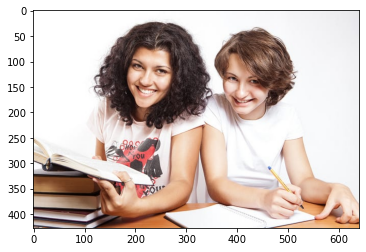

(427, 640, 3)


In [31]:
readImg('test1.jpg', show=True);

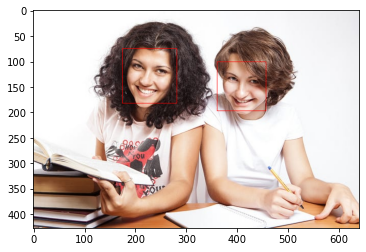

In [32]:
hightlineFaces(readImg('test1.jpg'), count=None)

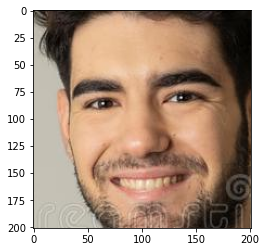

In [33]:
for img in getFace(readImg('test13.jpg')):
    showImg(img)

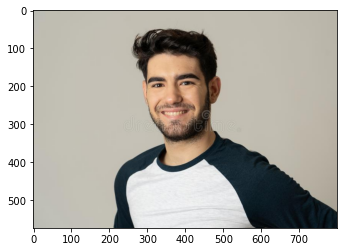

(573, 800, 3)


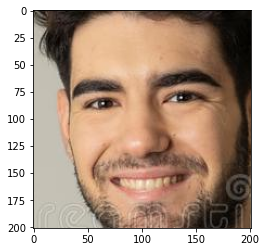

Happy
Happy 70.4%
Neutral 21.9%
Bad 7.7%


In [233]:
readImg('test13.jpg', True)
for img in getFace(readImg('test13.jpg')):
    showImg(img)
    predictOne(model, img, classes_train, 'cuda', show=False, masks=masks, mode='mask')

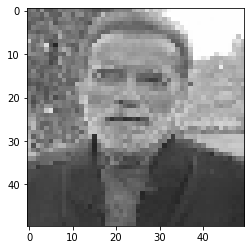

In [232]:
predictOne(model, readImg('test6.jpg'), classes_train, 'cuda', show=True)

In [164]:
device = get_default_device()
device

device(type='cuda')

In [165]:
# Looking into the directory
data_dir = './fer'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['train', 'validation']
Train Classes - ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
Validation Classes - ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [166]:
masks = {
    'Angry': 'Bad',
    'Disgust': 'Bad',
    'Fear': 'Neutral',
    'Happy': 'Happy',
    'Neutral': 'Neutral',
    'Sad': 'Bad',
    'Surprise': 'Neutral'
}

mask_labels = {
    0: 1,
    1: 1,
    2: 0,
    3: 2,
    4: 0,
    5: 1,
    6: 0
}

mask_labels_names = list(set(masks.values()))

mask_labels_names

['Happy', 'Neutral', 'Bad']

In [167]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [169]:
batch_size = 200

train_dl = getDataLoader(data_dir + '/train', batch_size, cut=False, shuffle=True, num_workers=3)
valid_dl = getDataLoader(data_dir + '/validation', batch_size * 2, cut=False, num_workers=3)

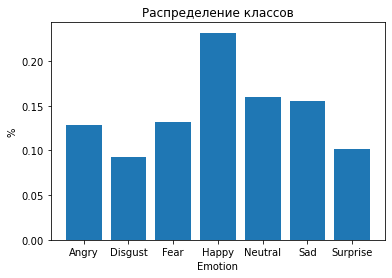

In [170]:
classDist(data_dir + "/train/", classes_train)

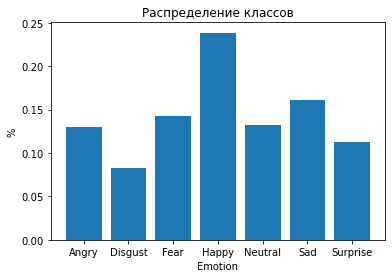

In [171]:
classDist(data_dir + "/validation/", classes_train)

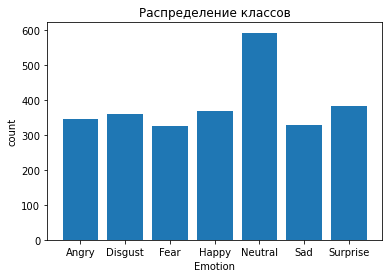

In [172]:
classDist('./CK/', classes_train, False)

In [132]:
augmenters = {
    'Rotate': tt.RandomRotation(degrees=(-15, 15)),
    'HFlip': tt.RandomHorizontalFlip(p=1),
    'Rotate2': tt.RandomRotation(degrees=(-20, 20)),
    'HFlip2': tt.RandomHorizontalFlip(p=1)
}

dir_ds = './CK/'
dir_ds_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

#cnt = 300
for cl in dir_ds_classes:
    cnt = 300
    for k in range(0, 1000):
        for images in os.listdir(dir_ds + cl):
            if (images.endswith(".png")):
                #print(images)
                images = imread(dir_ds + cl + '/' + images)
                images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
                images = PIL.Image.fromarray(images)
                augmenter = random.choice(list(augmenters.values()))
                aug_img = augmenter(images)
                aug_img.save(f"{dir_ds + cl}/{i.split('.')[0]}_{cl+str(cnt)}.png")
                print('add '+cl+str(300-cnt+1))
            
            if cnt == 0:
                break
            cnt -= 1
        if cnt == 0:
            break

add Angry1
add Angry2
add Angry3
add Angry4
add Angry5
add Angry6
add Angry7
add Angry8
add Angry9
add Angry10
add Angry11
add Angry12
add Angry13
add Angry14
add Angry15
add Angry16
add Angry17
add Angry18
add Angry19
add Angry20
add Angry21
add Angry22
add Angry23
add Angry24
add Angry25
add Angry26
add Angry27
add Angry28
add Angry29
add Angry30
add Angry31
add Angry32
add Angry33
add Angry34
add Angry35
add Angry36
add Angry37
add Angry38
add Angry39
add Angry40
add Angry41
add Angry42
add Angry43
add Angry44
add Angry45
add Angry46
add Angry47
add Angry48
add Angry49
add Angry50
add Angry51
add Angry52
add Angry53
add Angry54
add Angry55
add Angry56
add Angry57
add Angry58
add Angry59
add Angry60
add Angry61
add Angry62
add Angry63
add Angry64
add Angry65
add Angry66
add Angry67
add Angry68
add Angry69
add Angry70
add Angry71
add Angry72
add Angry73
add Angry74
add Angry75
add Angry76
add Angry77
add Angry78
add Angry79
add Angry80
add Angry81
add Angry82
add Angry83
add Angry84
a

add Fear1
add Fear2
add Fear3
add Fear4
add Fear5
add Fear6
add Fear7
add Fear8
add Fear9
add Fear10
add Fear11
add Fear12
add Fear13
add Fear14
add Fear15
add Fear16
add Fear17
add Fear18
add Fear19
add Fear20
add Fear21
add Fear22
add Fear23
add Fear24
add Fear25
add Fear26
add Fear27
add Fear28
add Fear29
add Fear30
add Fear31
add Fear32
add Fear33
add Fear34
add Fear35
add Fear36
add Fear37
add Fear38
add Fear39
add Fear40
add Fear41
add Fear42
add Fear43
add Fear44
add Fear45
add Fear46
add Fear47
add Fear48
add Fear49
add Fear50
add Fear51
add Fear52
add Fear53
add Fear54
add Fear55
add Fear56
add Fear57
add Fear58
add Fear59
add Fear60
add Fear61
add Fear62
add Fear63
add Fear64
add Fear65
add Fear66
add Fear67
add Fear68
add Fear69
add Fear70
add Fear71
add Fear72
add Fear73
add Fear74
add Fear75
add Fear76
add Fear77
add Fear78
add Fear79
add Fear80
add Fear81
add Fear82
add Fear83
add Fear84
add Fear85
add Fear86
add Fear87
add Fear88
add Fear89
add Fear90
add Fear91
add Fear

add Sad93
add Sad94
add Sad95
add Sad96
add Sad97
add Sad98
add Sad99
add Sad100
add Sad101
add Sad102
add Sad103
add Sad104
add Sad105
add Sad106
add Sad107
add Sad108
add Sad109
add Sad110
add Sad111
add Sad112
add Sad113
add Sad114
add Sad115
add Sad116
add Sad117
add Sad118
add Sad119
add Sad120
add Sad121
add Sad122
add Sad123
add Sad124
add Sad125
add Sad126
add Sad127
add Sad128
add Sad129
add Sad130
add Sad131
add Sad132
add Sad133
add Sad134
add Sad135
add Sad136
add Sad137
add Sad138
add Sad139
add Sad140
add Sad141
add Sad142
add Sad143
add Sad144
add Sad145
add Sad146
add Sad147
add Sad148
add Sad149
add Sad150
add Sad151
add Sad152
add Sad153
add Sad154
add Sad155
add Sad156
add Sad157
add Sad158
add Sad159
add Sad160
add Sad161
add Sad162
add Sad163
add Sad164
add Sad165
add Sad166
add Sad167
add Sad168
add Sad169
add Sad170
add Sad171
add Sad172
add Sad173
add Sad174
add Sad175
add Sad176
add Sad177
add Sad178
add Sad179
add Sad180
add Sad181
add Sad182
add Sad183
add Sa

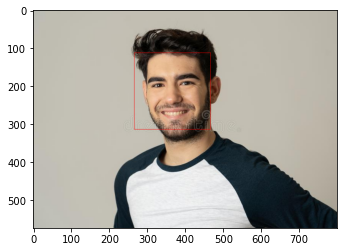

In [42]:
hightlineFaces(readImg('./test13.jpg'), 5)

(279, 279, 3)


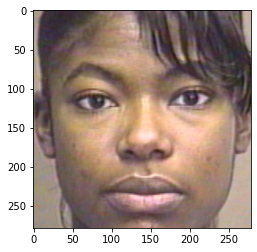

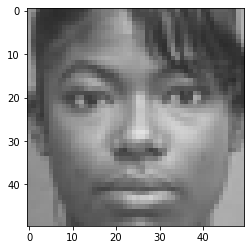

In [43]:
for img in getFace(readImg('./test8.png'), 1):
    print(img.shape)
    showImg(img)
    tfms = tt.Compose([tt.ToPILImage(),
                       tt.Grayscale(num_output_channels=1),
                       tt.Resize([int(50), int(50)])])
    showImg(np.array(tfms(img)))

torch.Size([1, 50, 50])


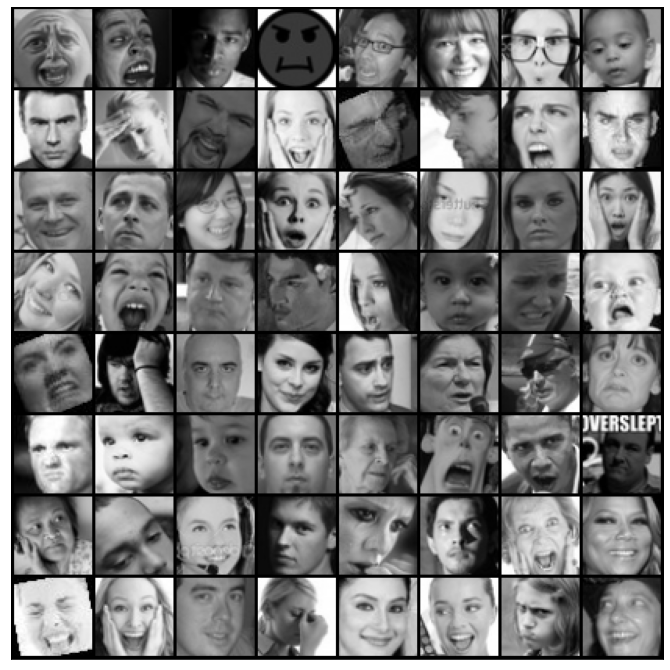

In [46]:
show_batch(train_dl)

torch.Size([1, 50, 50])


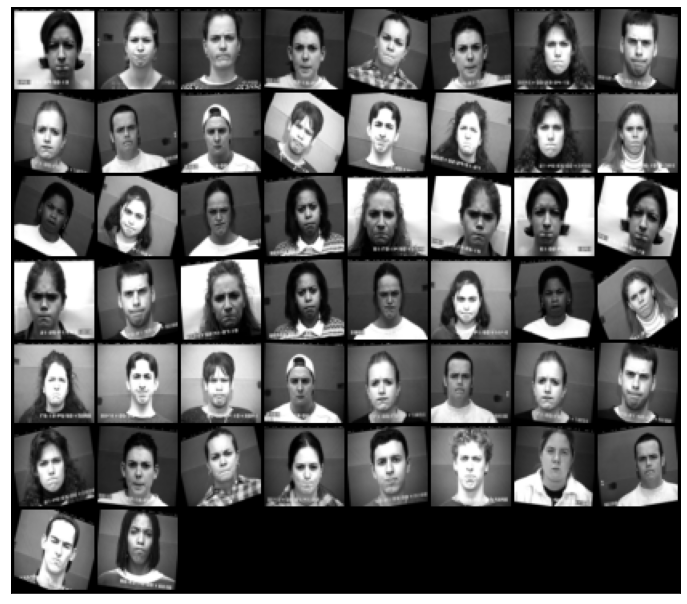

In [128]:
show_batch(getDataLoader('./CK', 50, cut=False, num_workers=0))

torch.Size([1, 50, 50])


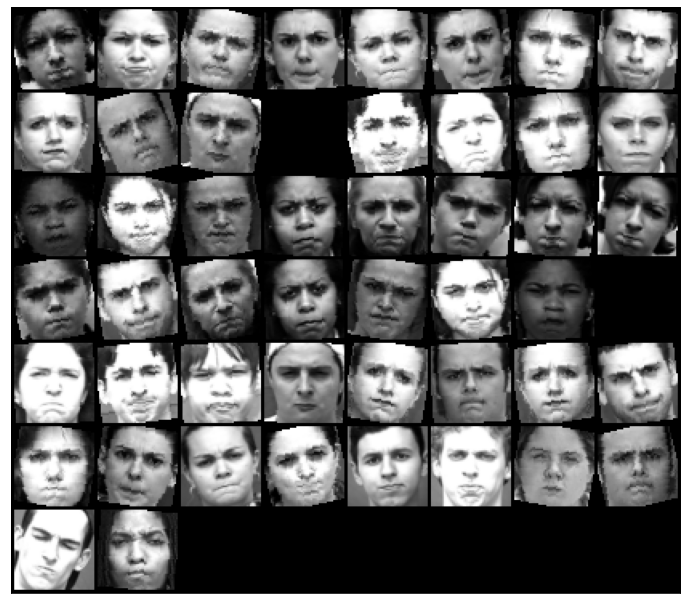

In [58]:
show_batch(getDataLoader('./CK', 50, cut=True, num_workers=0))

torch.Size([1, 50, 50])


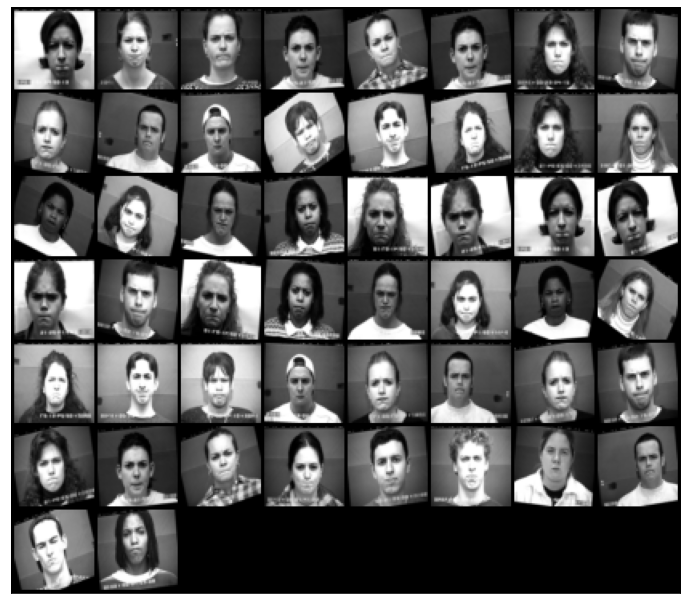

In [48]:
show_batch(getDataLoader('./CK', 50, cut=False, num_workers=0))

In [173]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [174]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9652607440948486, 'val_acc': 0.1145000010728836}]

In [175]:
epochs = 50
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [176]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00005, train_loss: 3.3392, val_loss: 2.0526, val_acc: 0.1237
Epoch [1], last_lr: 0.00008, train_loss: 1.9893, val_loss: 1.9848, val_acc: 0.1255
Epoch [2], last_lr: 0.00013, train_loss: 1.9312, val_loss: 1.9574, val_acc: 0.1265
Epoch [3], last_lr: 0.00020, train_loss: 1.8879, val_loss: 1.9094, val_acc: 0.1627
Epoch [4], last_lr: 0.00028, train_loss: 1.8132, val_loss: 1.9111, val_acc: 0.2340
Epoch [5], last_lr: 0.00037, train_loss: 1.6803, val_loss: 1.9756, val_acc: 0.2512
Epoch [6], last_lr: 0.00047, train_loss: 1.5692, val_loss: 1.7924, val_acc: 0.3380
Epoch [7], last_lr: 0.00057, train_loss: 1.4815, val_loss: 1.6539, val_acc: 0.3834
Epoch [8], last_lr: 0.00067, train_loss: 1.4155, val_loss: 1.6544, val_acc: 0.3856
Epoch [9], last_lr: 0.00076, train_loss: 1.3552, val_loss: 1.4526, val_acc: 0.4784
Epoch [10], last_lr: 0.00084, train_loss: 1.3109, val_loss: 1.4281, val_acc: 0.4822
Epoch [11], last_lr: 0.00091, train_loss: 1.2664, val_loss: 1.4759, val_acc: 0.4448
Ep

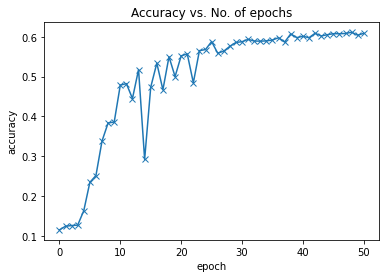

In [177]:
plot_accuracies(history)

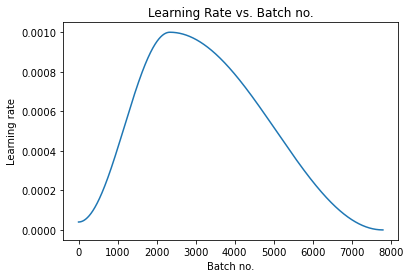

In [178]:
plot_lrs(history)

In [206]:
"Train acc = {}, validation acc = {}, ck = {}".format(calcAccuracy(model, train_dl, mask=True, mask_labels=mask_labels),
                                             calcAccuracy(model, valid_dl, mask=True, mask_labels=mask_labels),
                                             calcAccuracy(model, ckd_dl, mask=True, mask_labels=mask_labels))

'Train acc = 84.6%, validation acc = 73.3%, ck = 85.8%'

In [207]:
print("Train acc = {}, validation acc = {}, ck = {}".format(calcAccuracy(model, train_dl, 
                                                                multi_accuracy=True, labels=mask_labels_names,
                                                                mask=True, mask_labels=mask_labels),
                                             calcAccuracy(model, valid_dl,
                                                          multi_accuracy=True, labels=mask_labels_names,
                                                          mask=True, mask_labels=mask_labels),
                                            calcAccuracy(model, ckd_dl,
                                                          multi_accuracy=True, labels=mask_labels_names,
                                                          mask=True, mask_labels=mask_labels)))

Train acc = Happy: 80.8%, Neutral: 82.4%, Bad: 93.3%, validation acc = Happy: 61.8%, Neutral: 75.0%, Bad: 87.1%, ck = Happy: 90.2%, Neutral: 74.3%, Bad: 98.9%


In [181]:
classes_train

print("Train acc = {}, validation acc = {}".format(calcAccuracy(model, train_dl, 
                                                                multi_accuracy=True, labels=classes_train,
                                                                mask=False),
                                             calcAccuracy(model, valid_dl,
                                                         multi_accuracy=True, labels=classes_train,
                                                                mask=False)))

Train acc = Angry: 58.2%, Disgust: 98.3%, Fear: 33.5%, Happy: 89.6%, Neutral: 75.1%, Sad: 63.6%, Surprise: 86.0%, validation acc = Angry: 50.7%, Disgust: 91.5%, Fear: 23.6%, Happy: 86.6%, Neutral: 24.8%, Sad: 55.9%, Surprise: 79.7%


In [182]:
batch_size = 400

train_dl = getDataLoader(data_dir + '/train', batch_size, cut=False, shuffle=True, num_workers=3)
valid_dl = getDataLoader(data_dir + '/validation', batch_size * 2, cut=False, num_workers=3)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

history = [evaluate(model, valid_dl)]

In [183]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00005, train_loss: 0.8030, val_loss: 1.0870, val_acc: 0.6047
Epoch [1], last_lr: 0.00008, train_loss: 0.8008, val_loss: 1.0890, val_acc: 0.6070
Epoch [2], last_lr: 0.00013, train_loss: 0.8018, val_loss: 1.0933, val_acc: 0.6093
Epoch [3], last_lr: 0.00020, train_loss: 0.8058, val_loss: 1.0868, val_acc: 0.6038
Epoch [4], last_lr: 0.00028, train_loss: 0.8133, val_loss: 1.0957, val_acc: 0.6096
Epoch [5], last_lr: 0.00037, train_loss: 0.8199, val_loss: 1.1331, val_acc: 0.5940
Epoch [6], last_lr: 0.00047, train_loss: 0.8215, val_loss: 1.1660, val_acc: 0.5877
Epoch [7], last_lr: 0.00057, train_loss: 0.8331, val_loss: 1.1024, val_acc: 0.6018
Epoch [8], last_lr: 0.00067, train_loss: 0.8386, val_loss: 1.1423, val_acc: 0.5872
Epoch [9], last_lr: 0.00076, train_loss: 0.8432, val_loss: 1.1282, val_acc: 0.5886
Epoch [10], last_lr: 0.00084, train_loss: 0.8542, val_loss: 1.1152, val_acc: 0.5918
Epoch [11], last_lr: 0.00091, train_loss: 0.8568, val_loss: 1.1403, val_acc: 0.5895
Ep

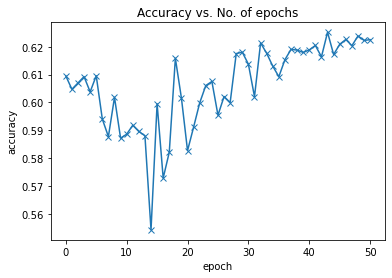

In [184]:
plot_accuracies(history)

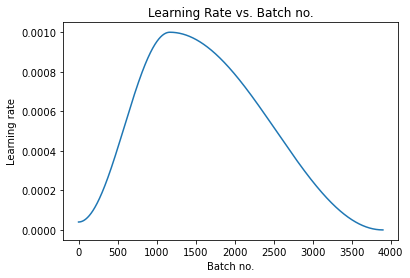

In [185]:
plot_lrs(history)

In [186]:
"Train acc = {}, validation acc = {}".format(calcAccuracy(model, train_dl),
                                             calcAccuracy(model, valid_dl),
                                             calcAccuracy(model, valid_dl))

'Train acc = 78.3%, validation acc = 61.7%'

In [187]:
print("Train acc = {}, validation acc = {}".format(calcAccuracy(model, train_dl, 
                                                                multi_accuracy=True, labels=classes_train,
                                                                mask=False),
                                             calcAccuracy(model, valid_dl,
                                                         multi_accuracy=True, labels=classes_train,
                                                                mask=False)))

Train acc = Angry: 66.7%, Disgust: 99.1%, Fear: 43.7%, Happy: 92.3%, Neutral: 82.5%, Sad: 70.2%, Surprise: 92.0%, validation acc = Angry: 53.0%, Disgust: 89.9%, Fear: 31.4%, Happy: 86.2%, Neutral: 24.2%, Sad: 56.2%, Surprise: 83.6%


In [198]:
h = torch.as_tensor([4, 2, 4, 4, 0, 6, 2, 4, 5, 5, 0, 3, 2, 2, 4, 6, 6, 2, 3, 1, 3, 5, 0, 0,
        1, 2, 5, 2, 4, 1, 2, 5, 0, 3, 0, 3, 3, 4, 5, 3, 5, 4, 0, 4, 2, 3, 1, 6,
        0, 3, 2, 3, 5, 0, 3, 4, 1, 2, 0, 5, 2, 5, 1, 0, 5, 4, 5, 5, 3, 3, 4, 2,
        3, 5, 3, 3, 0, 4, 3, 0, 3, 0, 3, 6, 5, 3, 3, 6, 3, 6, 4, 0, 4, 3, 1, 3,
        3, 3, 0, 2, 4, 2, 2, 5, 3, 2, 3, 4, 5, 6, 2, 3, 0, 2, 3, 2, 5, 1, 2, 5,
        3, 6, 5, 3, 5, 1, 6, 3, 2, 3, 6, 2, 2, 3, 0, 0, 3, 3, 3, 3, 1, 5, 3, 2,
        3, 2, 0, 2, 0, 4, 3, 4, 3, 0, 0, 2, 2, 1, 5, 5, 4, 1, 5, 2, 0, 4, 3, 5,
        5, 4, 1, 2, 5, 5, 0, 0, 6, 1, 6, 5, 0, 2, 6, 4, 1, 3, 3, 0, 4, 6, 4, 5,
        4, 3, 5, 0, 0, 2, 2, 3, 0, 0, 2, 5, 5, 4, 5, 3, 3, 2, 6, 5, 2, 6, 3, 1,
        4, 5, 4, 3, 3, 6, 0, 2, 5, 5, 0, 5, 5, 5, 2, 1, 6, 5, 3, 4, 1, 5, 3, 6,
        4, 4, 3, 2, 4, 1, 2, 1, 5, 3, 5, 5, 0, 6, 5, 2, 3, 5, 5, 0, 4, 2, 5, 5,
        0, 1, 4, 3, 3, 4, 2, 3, 0, 3, 3, 4, 3, 3, 3, 4, 3, 1, 4, 3, 5, 4, 2, 0,
        3, 3, 3, 3, 3, 2, 1, 4, 6, 5, 5, 6, 0, 4, 1, 0, 3, 4, 5, 6, 5, 5, 5, 4,
        4, 2, 0, 5, 3, 1, 0, 2, 2, 2, 2, 3, 4, 3, 0, 3, 5, 0, 5, 5, 6, 4, 0, 6,
        3, 3, 2, 0, 4, 1, 6, 1, 0, 3, 6, 3, 5, 1, 4, 3, 0, 3, 5, 3, 1, 2, 3, 5,
        4, 5, 4, 2, 4, 5, 4, 2, 0, 3, 2, 3, 6, 3, 0, 2, 5, 5, 3, 5, 1, 2, 6, 5,
        5, 4, 0, 3, 0, 1, 3, 0, 5, 3, 2, 4, 3, 2, 4, 2])
d = dict([[i, i+1] for i in range(0, 7)])
for i in range(h.shape[0]):
    h[i] = d[h[i].item()]
h

tensor([5, 3, 5, 5, 1, 7, 3, 5, 6, 6, 1, 4, 3, 3, 5, 7, 7, 3, 4, 2, 4, 6, 1, 1,
        2, 3, 6, 3, 5, 2, 3, 6, 1, 4, 1, 4, 4, 5, 6, 4, 6, 5, 1, 5, 3, 4, 2, 7,
        1, 4, 3, 4, 6, 1, 4, 5, 2, 3, 1, 6, 3, 6, 2, 1, 6, 5, 6, 6, 4, 4, 5, 3,
        4, 6, 4, 4, 1, 5, 4, 1, 4, 1, 4, 7, 6, 4, 4, 7, 4, 7, 5, 1, 5, 4, 2, 4,
        4, 4, 1, 3, 5, 3, 3, 6, 4, 3, 4, 5, 6, 7, 3, 4, 1, 3, 4, 3, 6, 2, 3, 6,
        4, 7, 6, 4, 6, 2, 7, 4, 3, 4, 7, 3, 3, 4, 1, 1, 4, 4, 4, 4, 2, 6, 4, 3,
        4, 3, 1, 3, 1, 5, 4, 5, 4, 1, 1, 3, 3, 2, 6, 6, 5, 2, 6, 3, 1, 5, 4, 6,
        6, 5, 2, 3, 6, 6, 1, 1, 7, 2, 7, 6, 1, 3, 7, 5, 2, 4, 4, 1, 5, 7, 5, 6,
        5, 4, 6, 1, 1, 3, 3, 4, 1, 1, 3, 6, 6, 5, 6, 4, 4, 3, 7, 6, 3, 7, 4, 2,
        5, 6, 5, 4, 4, 7, 1, 3, 6, 6, 1, 6, 6, 6, 3, 2, 7, 6, 4, 5, 2, 6, 4, 7,
        5, 5, 4, 3, 5, 2, 3, 2, 6, 4, 6, 6, 1, 7, 6, 3, 4, 6, 6, 1, 5, 3, 6, 6,
        1, 2, 5, 4, 4, 5, 3, 4, 1, 4, 4, 5, 4, 4, 4, 5, 4, 2, 5, 4, 6, 5, 3, 1,
        4, 4, 4, 4, 4, 3, 2, 5, 7, 6, 6,

In [210]:
TFEID_dl = getDataLoader('./TFEID', 50, cut=False, num_workers=0)
TFEID_dl = DeviceDataLoader(TFEID_dl, device)
calcAccuracy(model, TFEID_dl)

'71.1%'

In [222]:
calcAccuracy(model, TFEID_dl, mask=True, mask_labels=mask_labels)

'88.4%'

In [212]:
calcAccuracy(model, TFEID_dl,  multi_accuracy=True, labels=classes_train, mask=False)

'Angry: 67.6%, Disgust: 37.5%, Fear: 25.0%, Happy: 100.0%, Neutral: 100.0%, Sad: 59.0%, Surprise: 97.2%'

In [221]:
calcAccuracy(model, TFEID_dl,  multi_accuracy=True, labels=mask_labels_names, mask=True, mask_labels=mask_labels)

'Happy: 84.3%, Neutral: 87.6%, Bad: 100.0%'

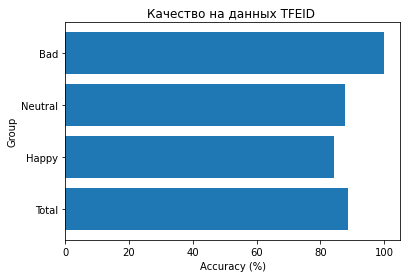

In [227]:
#plt.hist([88.7, 84.3, 87.6, 100.0])
plt.barh(['Total', 'Happy', 'Neutral', 'Bad'], [88.7, 84.3, 87.6, 100.0])
plt.title('Качество на данных TFEID ')
plt.ylabel('Group')
plt.xlabel('Accuracy (%)')
plt.show()

torch.Size([1, 50, 50])


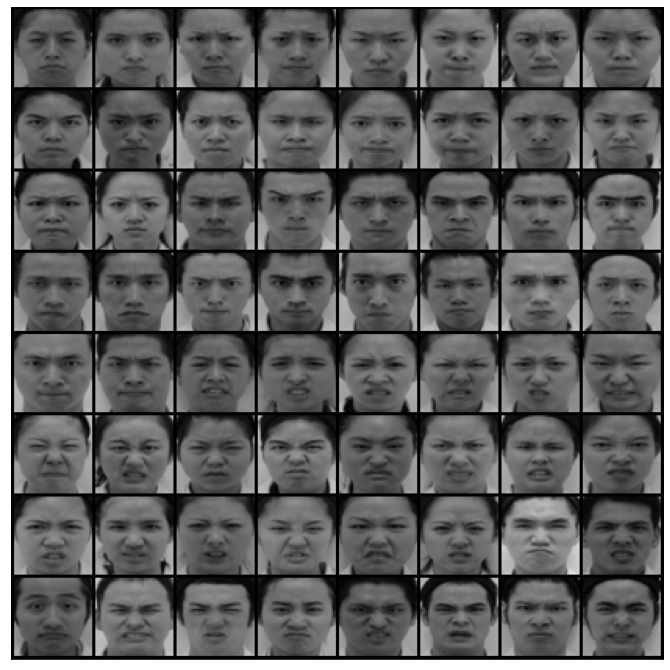

In [228]:
show_batch(getDataLoader('./TFEID', 100, cut=False, num_workers=0))

In [188]:
ckd_dl = getDataLoader('./CK', 200, cut=True, num_workers=0, train=False)

In [189]:
ckd_dl = DeviceDataLoader(ckd_dl, device)

In [190]:
%%time
history += fit_one_cycle(20, max_lr, model, ckd_dl, ckd_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00009, train_loss: 2.0722, val_loss: 0.7726, val_acc: 0.7460
Epoch [1], last_lr: 0.00026, train_loss: 1.8488, val_loss: 0.7007, val_acc: 0.7681
Epoch [2], last_lr: 0.00050, train_loss: 1.5166, val_loss: 0.6518, val_acc: 0.7661
Epoch [3], last_lr: 0.00075, train_loss: 1.2562, val_loss: 0.6309, val_acc: 0.7696
Epoch [4], last_lr: 0.00093, train_loss: 1.0465, val_loss: 0.5913, val_acc: 0.7756
Epoch [5], last_lr: 0.00100, train_loss: 0.9332, val_loss: 0.5580, val_acc: 0.8092
Epoch [6], last_lr: 0.00099, train_loss: 0.7940, val_loss: 0.5463, val_acc: 0.8306
Epoch [7], last_lr: 0.00095, train_loss: 0.6816, val_loss: 0.5363, val_acc: 0.8494
Epoch [8], last_lr: 0.00089, train_loss: 0.6424, val_loss: 0.5069, val_acc: 0.8679
Epoch [9], last_lr: 0.00081, train_loss: 0.5578, val_loss: 0.4925, val_acc: 0.8676
Epoch [10], last_lr: 0.00072, train_loss: 0.5053, val_loss: 0.4715, val_acc: 0.8845
Epoch [11], last_lr: 0.00061, train_loss: 0.4638, val_loss: 0.4832, val_acc: 0.8916
Ep

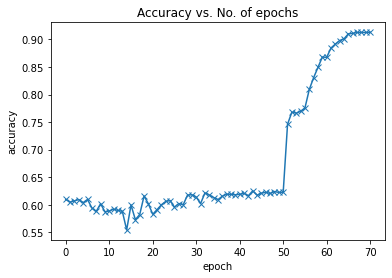

In [194]:
plot_accuracies(history)

In [192]:
"Train acc = {}, validation acc = {}, CK acc = {}".format(calcAccuracy(model, train_dl),
                                                          calcAccuracy(model, valid_dl),
                                                          calcAccuracy(model, ckd_dl))

'Train acc = 49.9%, validation acc = 42.7%, CK acc = 91.3%'

In [193]:
print("Train acc = {}, validation acc = {}, CK acc = {}".format(calcAccuracy(model, train_dl, 
                                                                multi_accuracy=True, labels=classes_train,
                                                                mask=False),
                                                                calcAccuracy(model, valid_dl,
                                                                multi_accuracy=True, labels=classes_train,
                                                                mask=False),
                                                                calcAccuracy(model, ckd_dl,
                                                                multi_accuracy=True, labels=classes_train,
                                                                mask=False)))

Train acc = Angry: 0.8%, Disgust: 48.1%, Fear: 35.0%, Happy: 78.6%, Neutral: 87.8%, Sad: 9.2%, Surprise: 70.1%, validation acc = Angry: 0.6%, Disgust: 46.7%, Fear: 30.6%, Happy: 77.6%, Neutral: 48.7%, Sad: 6.2%, Surprise: 65.2%, CK acc = Angry: 64.2%, Disgust: 98.9%, Fear: 92.0%, Happy: 98.9%, Neutral: 99.5%, Sad: 77.2%, Surprise: 98.4%


In [60]:
"Train acc = {}, validation acc = {}, CK acc = {}".format(calcAccuracy(model, train_dl, mask=True, mask_labels=mask_labels),
                                                          calcAccuracy(model, valid_dl, mask=True, mask_labels=mask_labels),
                                                          calcAccuracy(model, ckd_dl, mask=True, mask_labels=mask_labels))

'Train acc = 81.3%, validation acc = 73.9%, CK acc = 83.4%'

In [195]:
batch_size = 400

train_dl = getDataLoader(data_dir + '/train', batch_size, cut=False, shuffle=True, num_workers=3)
valid_dl = getDataLoader(data_dir + '/validation', batch_size * 2, cut=False, num_workers=3)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

history = [evaluate(model, valid_dl)]

In [196]:
%%time
history += fit_one_cycle(10, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00028, train_loss: 1.0519, val_loss: 1.0982, val_acc: 0.5967
Epoch [1], last_lr: 0.00076, train_loss: 0.7594, val_loss: 1.0809, val_acc: 0.6068
Epoch [2], last_lr: 0.00100, train_loss: 0.7686, val_loss: 1.1043, val_acc: 0.5913
Epoch [3], last_lr: 0.00095, train_loss: 0.7663, val_loss: 1.0987, val_acc: 0.6101
Epoch [4], last_lr: 0.00081, train_loss: 0.7641, val_loss: 1.0833, val_acc: 0.6064
Epoch [5], last_lr: 0.00061, train_loss: 0.7487, val_loss: 1.0781, val_acc: 0.6165
Epoch [6], last_lr: 0.00039, train_loss: 0.7242, val_loss: 1.0605, val_acc: 0.6136
Epoch [7], last_lr: 0.00019, train_loss: 0.6990, val_loss: 1.0600, val_acc: 0.6216
Epoch [8], last_lr: 0.00005, train_loss: 0.6820, val_loss: 1.0501, val_acc: 0.6208
Epoch [9], last_lr: 0.00000, train_loss: 0.6721, val_loss: 1.0513, val_acc: 0.6261
Wall time: 2min 21s


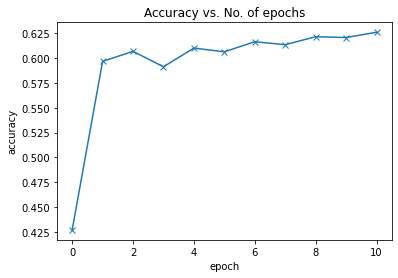

In [197]:
plot_accuracies(history)

In [198]:
"Train acc = {}, validation acc = {}, CK acc = {}".format(calcAccuracy(model, train_dl),
                                                          calcAccuracy(model, valid_dl),
                                                          calcAccuracy(model, ckd_dl))

'Train acc = 78.3%, validation acc = 61.9%, CK acc = 72.3%'

In [199]:
print("Train acc = {}, validation acc = {}, CK acc = {}".format(calcAccuracy(model, train_dl, 
                                                                multi_accuracy=True, labels=classes_train,
                                                                mask=False),
                                                                calcAccuracy(model, valid_dl,
                                                                multi_accuracy=True, labels=classes_train,
                                                                mask=False),
                                                                calcAccuracy(model, ckd_dl,
                                                                multi_accuracy=True, labels=classes_train,
                                                                mask=False)))

Train acc = Angry: 66.5%, Disgust: 98.9%, Fear: 44.4%, Happy: 93.2%, Neutral: 82.4%, Sad: 69.0%, Surprise: 91.9%, validation acc = Angry: 53.0%, Disgust: 90.5%, Fear: 30.2%, Happy: 87.4%, Neutral: 22.8%, Sad: 55.9%, Surprise: 83.1%, CK acc = Angry: 40.8%, Disgust: 47.2%, Fear: 31.6%, Happy: 98.9%, Neutral: 97.5%, Sad: 62.6%, Surprise: 96.6%


In [200]:
print("Train acc = {}, validation acc = {}, CK acc = {}".format(calcAccuracy(model, train_dl, 
                                                                multi_accuracy=False, labels=classes_train,
                                                                mask=False),
                                                                calcAccuracy(model, valid_dl,
                                                                multi_accuracy=False, labels=classes_train,
                                                                mask=False),
                                                                calcAccuracy(model, ckd_dl,
                                                                multi_accuracy=False, labels=classes_train,
                                                                mask=False)))

Train acc = 78.4%, validation acc = 62.1%, CK acc = 72.3%


In [201]:
print("Train acc = {}, validation acc = {}, CK acc = {}".format(calcAccuracy(model, train_dl, 
                                                                multi_accuracy=False, labels=mask_labels,
                                                                mask=True),
                                                                calcAccuracy(model, valid_dl,
                                                                multi_accuracy=False, labels=mask_labels,
                                                                mask=True),
                                                                calcAccuracy(model, ckd_dl,
                                                                multi_accuracy=False, labels=mask_labels,
                                                                mask=True)))

TypeError: 'NoneType' object is not subscriptable

In [ ]:
print("Train acc = {}, validation acc = {}, CK acc = {}".format(calcAccuracy(model, train_dl, 
                                                                multi_accuracy=True, labels=mask_labels,
                                                                mask=True),
                                                                calcAccuracy(model, valid_dl,
                                                                multi_accuracy=True, labels=mask_labels,
                                                                mask=True),
                                                                calcAccuracy(model, ckd_dl,
                                                                multi_accuracy=True, labels=mask_labels,
                                                                mask=True)))

In [260]:
saveModelW(model)

In [141]:
loadModelW(model, fname="emotion_detection_model_state.pth", device='cuda')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

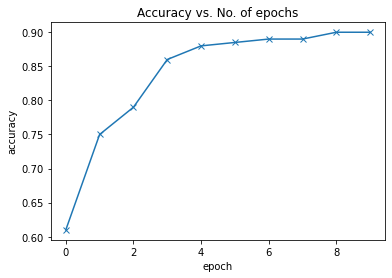

In [259]:
accuracies = [.61, .75, .79, .86, .88, .885, .89, .89, .9, .9]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

Значения для 6 клаасов

'Train acc = 74.3%, validation acc = 62.8%, CK acc = 67.3%'

RFEID без обрезки 73.7%'

С обрезкой 50


Такой анонс на главы больше подойдет для введения, чем для заключения. В заключении надо привести результаты исследования. Проведен анализ, в результате которого … Доказана целесообразность использования модели сверточной нейронной сети.. Разработано… и т.д. 

The purpose of the work is to consider existing methods and ready-made software solutions for emotion recognition and the implementation of its own software for recognizing a set of basic emotions by facial expression when assessing the level of customer satisfaction with lending processes.

Целью работы является рассмотрение существующих методов и готовых программных решений для распознавания эмоций и реализация собственного программного средства распознавания набора базовых эмоций по лицевой экспрессии при оценке уровня удовлетворенности клиентов процессами кредитования.

БК ЦЭ ИРИО

Комлева Н.В.